# Assignment 9

Use data from `https://github.com/thedenaas/hse_seminars/tree/master/2018/seminar_13/data.zip`  
Implement model in pytorch from "An Unsupervised Neural Attention Model for Aspect Extraction, He et al, 2017", also desribed in seminar notes.  

You can use sentence embeddings with attention **[7 points]**:  
$z_s = \sum_{i}^n \alpha_i e_{w_i}, z_s \in R^d$ sentence embedding  
$\alpha_i = softmax(d_i)$  attention weight for i-th token  
$d_i = e_{w_i}^T M y_s$ attention with trainable matrix $M \in R^{dxd}$  
$y_s = \frac 1 n \sum_{i=1}^n e_{w_i}, y_s \in R^d$ sentence context  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  

**Or** just use sentence embedding as an average over word embeddings **[5 points]**:  
$z_s = \frac 1 n \sum_{i=1}^n e_{w_i}, z_s \in R^d$ sentence embedding  
$e_{w_i} \in R^d$, token embedding of size d  
$n$ - number of tokens in a sentence  
 
$p_t = softmax(W z_s + b), p_t \in R^K$ topic weights for sentence $s$, with trainable matrix $W \in R^{dxK}$ and bias vector $b \in R^K$  
$r_s = T^T p_t, r_s \in R^d$ reconstructed sentence embedding as a weighted sum of topic embeddings   
$T \in R^{Kxd}$ trainable matrix of topic embeddings, K=number of topics


**Training objective**:
$$ J = \sum_{s \in D} \sum_{i=1}^n max(0, 1-r_s^T z_s + r_s^T n_i) + \lambda ||T^T T - I ||^2_F  $$
where   
$m$ random sentences are sampled as negative examples from dataset $D$ for each sentence $s$  
$n_i = \frac 1 n \sum_{i=j}^n e_{w_j}$ average of word embeddings in the i-th sentence  
$||T^T T - I ||_F$ regularizer, that enforces matrix $T$ to be orthogonal  
$||A||^2_F = \sum_{i=1}^N\sum_{j=1}^M a_{ij}^2, A \in R^{NxM}$ Frobenius norm


**[3 points]** Compute topic coherence for at least for 3 different number of topics. Use 10 nearest words for each topic. It means you have to train one model for each number of topics. You can use code from seminar notes with word2vec similarity scores.

## For Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import nltk
import spacy 

import torch
from torchtext.data import Field, TabularDataset, BucketIterator
from torchtext.vocab import Vectors
from gensim.models import Word2Vec, KeyedVectors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_state = 123

In [129]:
nltk.download('punkt')
spacy_en = spacy.load('en')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
NEG_SAMPLE = 1 

BATCH_SIZE = 64
 


## Opening and Preprocessing

In [6]:
!wget -O data.zip https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true
!unzip '/content/data.zip'

--2020-03-22 15:15:01--  https://github.com/thedenaas/hse_seminars/blob/master/2018/seminar_13/data.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/thedenaas/hse_seminars/raw/master/2018/seminar_13/data.zip [following]
--2020-03-22 15:15:01--  https://github.com/thedenaas/hse_seminars/raw/master/2018/seminar_13/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2018/seminar_13/data.zip [following]
--2020-03-22 15:15:02--  https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2018/seminar_13/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

In [131]:
with open('/content/data.txt', 'r') as f:
    data = f.read()
    data = nltk.tokenize.sent_tokenize(data)

print('data length: {len(data)}')
print(data[-1])


data length: {len(data)}
There’s a playful visual flair to this moment that is sadly lacking elsewhere in the film.


In [132]:
with open('/content/stopwords.txt', 'r') as f:
    stopwords = f.read()
    stopwords = stopwords.splitlines()

print(len(stopwords))
print(stopwords[-1])

350
yr


In [0]:
import pandas as pd
import numpy as np

In [0]:
def create_df(texts):
    dataframe = pd.DataFrame()
    dataframe['text'] = texts
    dataframe['neg_{}'.format(i)] = [texts[ind] if ind != el else texts[23] for el, ind in enumerate(np.random.choice(np.arange(0,len(texts)), size=len(texts)))]
    return df

In [0]:
df = create_df(data)


In [138]:
df.head(10)

,text,neg_1
0,Barclays' defiance of US fines has merit Barcl...,"48 min: Kolarov puts the ball out play, and it..."
1,"So it is tempting to think the bank, when aske...",“What I remember most in this moment of painfu...
2,"That is not the view of the chief executive, J...",72 mins: Milner curls over a corner that Boruc...
3,Barclays thinks the DoJ’s claims are “disconne...,Do people have to have a disease in order to g...
4,"But actually, some grudging respect for Staley...","Imagine the rage, the mass defections to Ukip,..."
5,The US system for dishing out fines to errant ...,Nothing they have done ought to take anybody b...
6,The approach prefers settlements behind closed...,"Arriving at the meeting on Monday, Johnson str..."
7,Occasional leaks of the negotiating demands ma...,As iIm in Ireland it would make sense to reque...
8,Deutsche Bank was initially asked for $14bn (£...,Federal Reserve chair Janet Yellen has warned ...
9,Where is the rhyme or reason?,"Just 200 plaster models, which were painted by..."


In [0]:
df.to_csv('data.csv', index=False)

In [0]:
def tokenizer(t):
  
    token_list = []
    for tok in spacy_en.tokenizer(t):
        if tok.text.isalpha():
            token_list.append(tok.lemma_)
    
    return token_list


In [0]:
data_tokenized = list(df['text'].apply(lambda x: tokenizer(x)))
model = Word2Vec(data_tokenized, size=200, window=10, negative=5)  
model_weights = torch.FloatTensor(model.wv.vectors)

In [142]:
model.wv.save_word2vec_format('emb_pretrained')
vectors = Vectors(name='emb_pretrained', cache='./') 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
TEXT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, stop_words=stopwords)

RESULT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize, stop_words=stopwords)

dataset = TabularDataset(path="/content/data.csv", format='csv', skip_header=True, fields=[('text', TEXT),('neg', TEXT)]) 

TEXT.build_vocab(dataset, min_freq=2, vectors=vectors, unk_init = torch.Tensor.normal_)

RESULT.build_vocab(dataset, min_freq=2, vectors=vectors, unk_init = torch.Tensor.normal_)

vocab = TEXT.vocab

In [145]:
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 56863


['<unk>',
 '<pad>',
 'The',
 '-PRON-',
 'I',
 'Trump',
 'go',
 'people',
 'get',
 'time']

In [0]:
train, test = dataset.split(0.7)
train, valid = train.split(0.7)

In [0]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(BATCH_SIZE, BATCH_SIZE, BATCH_SIZE),
    shuffle=True,
    sort_key=lambda x: len(x.text),
    device=device
)

## Making Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class MyModel(nn.Module):

    def __init__(self, vocab_size, embed_size, topics_size):
        super(MyModel, self).__init__()
        
        self.voc_size = vocab_size
        self.emb_size = embed_size
        self.top_size = topics_size

        self.embeddings = nn.Embedding(self.voc_size, self.emb_size)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.requires_gra = False 

        self.fc1 = nn.Linear(self.emb_size, self.top_size)  
        self.fc2 = nn.Linear(self.top_size, self.emb_size)  

        self.bias = None


    def sentence_embeddings(self, x):
        '''
        input: (batch_size, seq_length, embed_size)
        output: (batch_size, embed_size)
        '''
        x = torch.sum(x, dim=1)/x.size()
        return x[1]

    
    def forward(self, batch):
        
        text = batch.text
        neg = batch.neg

        text_true = self.sentence_embeddings(self.embeddings(text))
        neg = self.sentence_embeddings(self.embeddings(neg))

        
        text_out = self.fc1(text_true)
        text_out = F.softmax(text_out, dim=1)
        text_out = self.fc2(text_out)

        return text_true, text_out, neg

In [0]:
model = MyModel(vocab_size=len(vocab), embed_size=100, topics_size=10)
model.to(device)

optimizer = optim.Adam(model.parameters())

In [0]:
# taken from:  https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

class LossFunction(nn.Module):

    def __init__(self):
        super(LossFunction, self).__init__()

    def forward(self, emb_true, emb_pred, n1, T, lambd=1):
        loss_batch = 0
        for ind, e_true in enumerate(emb_true):
            temp = 1 - torch.dot(emb_pred[ind].T, e_true) + torch.dot(emb_pred[ind].T, n1[ind])
            t_max = F.relu(temp)
            loss_batch += t_max
        loss_batch += lambd * torch.norm(torch.mm(T.T, T) - torch.eye(T.size()[1], T.size(1)).to(device))
        return loss_batch / BATCH_SIZE

In [157]:
criterion = LossFunction()
criterion.to(device)

LossFunction()

In [0]:
train_losses = []
valid_losses = []

def _train_epoch(model, iterator, optimizer, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        text_true, text_out, neg = model(batch) 
        loss = criterion(text_true, text_out, neg, model.fc2.weight)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        train_losses.append(running_loss)
        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss


def _test_epoch(model, iterator):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            text_true, text_out, neg= model(batch)
            loss = criterion(text_true, text_out, neg, model.fc2.weight) 
            epoch_loss += loss.data.item()
            valid_losses.append(loss)

    return epoch_loss / n_batches


def nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 1000
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, epoch)
        valid_loss = _test_epoch(model, valid_iterator)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)


## Learning and watching........

In [166]:
from tqdm import tqdm_notebook

nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=10)# решил дообучить после трех эпох, поэтому лосс такой маленький начался. На графике все видно с первой эпохи

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan



validation loss nan


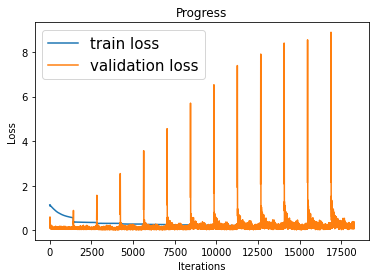

In [167]:
import matplotlib.pyplot as plt 

iterations = np.array(range(len(valid_losses)))*(len(train_losses)/len(valid_losses))
plt.plot(range(len(train_losses)), train_losses, iterations, valid_losses)

plt.legend(('train loss', 'validation loss'),prop={'size': 15})
plt.title('Progress')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.show()

At least I tried.... :'(